In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp

C:\Users\Cristiano\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ChessboardSegmentationDataset(Dataset):
    def __init__(self, data):
        self.data = data  # list of (image, mask) tuples

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, mask = self.data[idx]    
        return image, mask

In [3]:
train_data = torch.load("train.pt")
val_data = torch.load("valid.pt")

train_dataset = ChessboardSegmentationDataset(train_data)
val_dataset = ChessboardSegmentationDataset(val_data)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

C:\Users\Cristiano\AppData\Local\Temp\ipykernel_16136\2626672320.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load("train.pt")
C:\Users\Cristiano\A

In [4]:
from torchvision.ops import sigmoid_focal_loss

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,  # Binary segmentation
    decoder_dropout=0.5
)

loss_fn = lambda preds, targets: sigmoid_focal_loss(preds, targets, alpha=0.25, gamma=2.0, reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [5]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = 12

for epoch in range(0, epochs):  # 30 epochs, adjust as needed
    model.train()
    train_loss = 0.0

    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        preds = model(images)
        loss = loss_fn(preds, masks)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}")

    # Optionally validate
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            preds = model(images)

            loss = loss_fn(preds, masks)
            val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        print(f"[Epoch {epoch+1}] Val Loss: {avg_val_loss:.4f}")

100%|██████████| 546/546 [00:19<00:00, 28.05it/s]


[Epoch 1] Train Loss: 0.0197
[Epoch 1] Val Loss: 0.0192


100%|██████████| 546/546 [00:19<00:00, 28.34it/s]


[Epoch 2] Train Loss: 0.0168
[Epoch 2] Val Loss: 0.0190


100%|██████████| 546/546 [00:19<00:00, 28.33it/s]


[Epoch 3] Train Loss: 0.0161
[Epoch 3] Val Loss: 0.0199


100%|██████████| 546/546 [00:19<00:00, 28.42it/s]


[Epoch 4] Train Loss: 0.0153
[Epoch 4] Val Loss: 0.0226


100%|██████████| 546/546 [00:19<00:00, 28.41it/s]


[Epoch 5] Train Loss: 0.0145
[Epoch 5] Val Loss: 0.0232


100%|██████████| 546/546 [00:19<00:00, 28.39it/s]


[Epoch 6] Train Loss: 0.0140
[Epoch 6] Val Loss: 0.0232


100%|██████████| 546/546 [00:19<00:00, 28.32it/s]


[Epoch 7] Train Loss: 0.0133
[Epoch 7] Val Loss: 0.0233


100%|██████████| 546/546 [00:19<00:00, 28.24it/s]


[Epoch 8] Train Loss: 0.0127
[Epoch 8] Val Loss: 0.0244


100%|██████████| 546/546 [00:19<00:00, 28.28it/s]


[Epoch 9] Train Loss: 0.0123
[Epoch 9] Val Loss: 0.0269


100%|██████████| 546/546 [00:19<00:00, 28.37it/s]


[Epoch 10] Train Loss: 0.0116
[Epoch 10] Val Loss: 0.0266


100%|██████████| 546/546 [00:19<00:00, 28.28it/s]


[Epoch 11] Train Loss: 0.0110
[Epoch 11] Val Loss: 0.0264


100%|██████████| 546/546 [00:19<00:00, 28.39it/s]


[Epoch 12] Train Loss: 0.0102
[Epoch 12] Val Loss: 0.0334


In [6]:
torch.save(model.state_dict(), "chessboard_segmentation_unet.pth")

In [7]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch

def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def visualize_prediction(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        for images, true_masks in dataloader:
            images = images.to(device)
            true_masks = true_masks.to(device)

            # Predict masks
            preds = model(images)
            preds = torch.sigmoid(preds)  # sigmoid to get probs
            preds = (preds > 0.5).float()  # binary mask

            print(f"Logits stats: min={preds.min().item():.4f}, max={preds.max().item():.4f}, mean={preds.mean().item():.4f}")



            # Convert tensors to CPU for visualization
            for i in range(min(len(images), 4)):  # show up to 4
                img = images[i].cpu().clone()
                img = denormalize(img.clone(), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                img_pil = TF.to_pil_image(img)

                gt_mask = true_masks[i].squeeze().cpu().numpy()
                pred_mask = preds[i].squeeze().cpu().numpy()
                # print(gt_mask)    
                # print(pred_mask)
                
                # Plot
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.imshow(img_pil)
                plt.title("Image")

                plt.subplot(1, 3, 2)
                plt.imshow(gt_mask, cmap='gray')
                plt.title("Ground Truth Mask")

                plt.subplot(1, 3, 3)
                plt.imshow(img_pil)
                plt.imshow(pred_mask, cmap='Reds', alpha=0.4)
                plt.title("Predicted Mask Overlay")

                plt.tight_layout()
                plt.show()

            break  # Only visualize the first batch

Logits stats: min=0.0000, max=1.0000, mean=0.1897


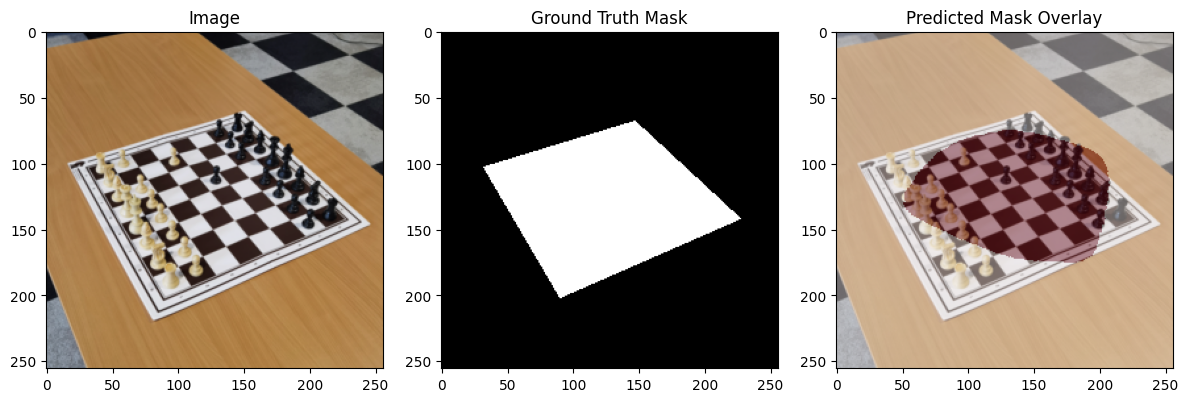

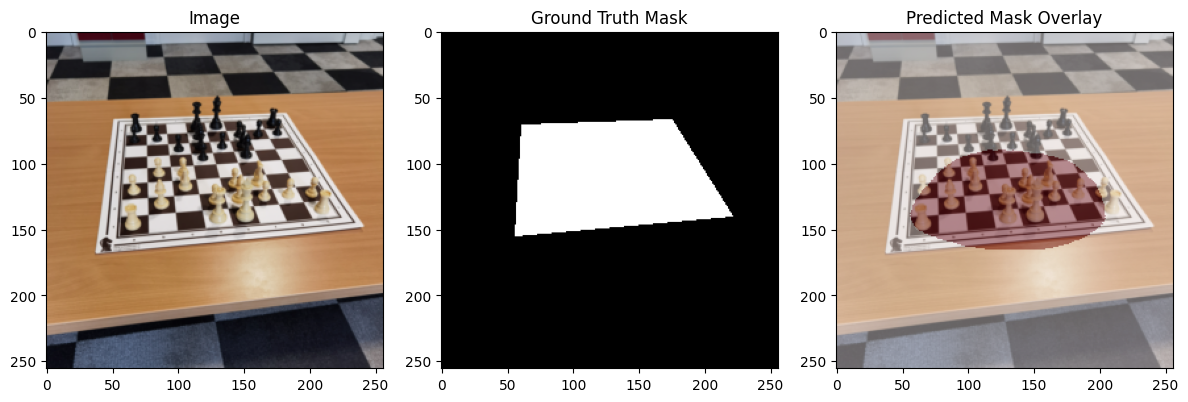

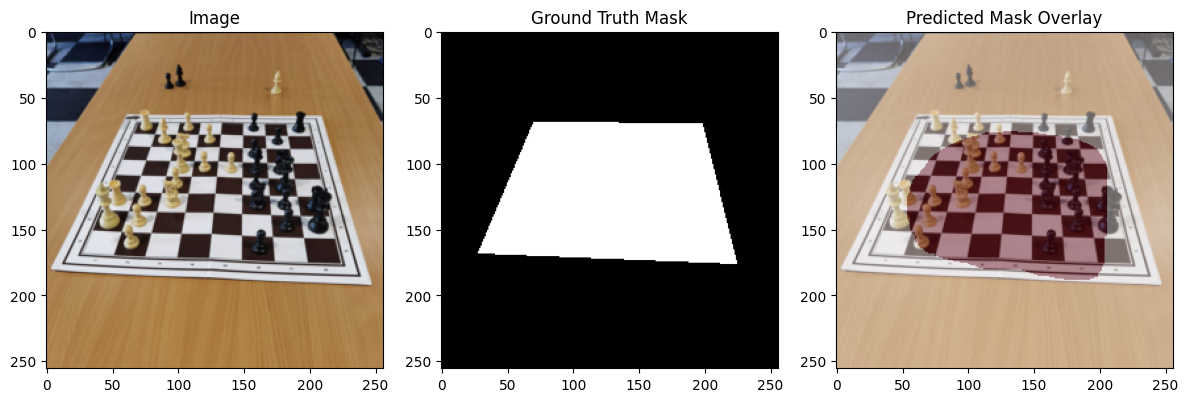

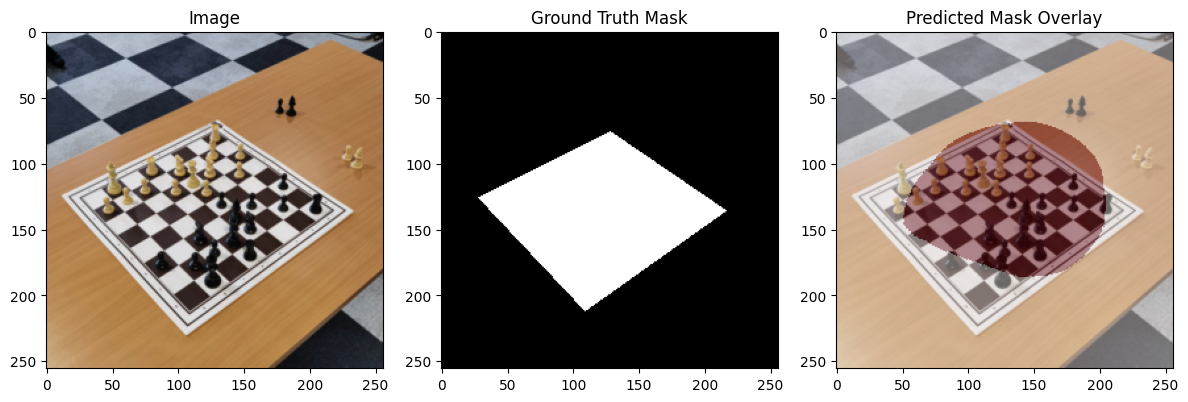

In [8]:
visualize_prediction(model, val_loader, device)